In [1]:
import torch
import torch.nn as nn
import torch.utils.data

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import math

### Generating and visualising training data

In [2]:
def get_samples(num_of_points, random=True):
    train_data = torch.zeros((num_of_points, 1))
    if random:
        freq = np.random.uniform(1.2, 1.5)
    else:
        freq = 1
    signal = np.array([np.sin(i*freq) for i in range(num_of_points)])
    train_data[:, 0] = torch.from_numpy(signal)
    
    return train_data

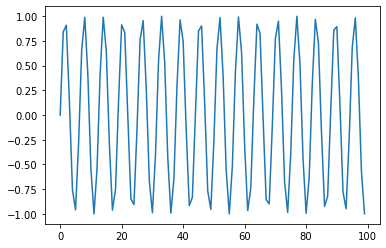

In [3]:
num_of_points = 100

train_data = get_samples(num_of_points, False)

plt.plot(train_data)

In [4]:
train_labels = torch.zeros(num_of_points)
train_dataset = [(train_data[i], train_labels[i]) for i in range(num_of_points)]

In [5]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=num_of_points)

In [6]:
print(train_loader)

### Defining models

In [7]:
class Discriminator(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, p=0.3):
        super().__init__()
        
       
        #layers
        self.hidden0 = nn.Sequential(
            nn.Linear(input_size, hidden_dim*4),
            nn.LeakyReLU(0.2),
            nn.Dropout(p)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(hidden_dim*4, hidden_dim*2),
            nn.LeakyReLU(0.2),
            nn.Dropout(p)
        )
        
        self.hidden2 = nn.Sequential(
            nn.Linear(hidden_dim*2, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(p)
        )
        
        self.out = nn.Sequential(
            nn.Linear(hidden_dim, output_size),
            nn.Sigmoid()
        )
       
    
        
    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        out = self.out(x)
        return out

In [8]:
class Generator(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, p=0.3):
        super().__init__()
          
    #layers
        self.hidden0 = nn.Sequential(
            nn.Linear(input_size, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(p)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim*2),
            nn.ReLU(inplace=True),
            nn.Dropout(p)
        )
        
        self.hidden2 = nn.Sequential(
            nn.Linear(hidden_dim*2, hidden_dim*4),
            nn.ReLU(inplace=True),
            nn.Dropout(p)
        )
        
        self.out = nn.Sequential(
            nn.Linear(hidden_dim*4, output_size),
            nn.Tanh()
        )
       
    
        
    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        out = self.out(x)
        return out

In [9]:
input_size = 1

d_output_size = 1
g_output_size = 1

hidden_dim = 64

In [10]:
D = Discriminator(input_size, d_output_size, hidden_dim)
G = Generator(input_size, g_output_size, hidden_dim)

In [11]:
print(D)

Discriminator(
  (hidden0): Sequential(
    (0): Linear(in_features=1, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
  )
  (hidden1): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
  )
  (hidden2): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
  )
  (out): Sequential(
    (0): Linear(in_features=64, out_features=1, bias=True)
    (1): Sigmoid()
  )
)


In [12]:
print(G)

Generator(
  (hidden0): Sequential(
    (0): Linear(in_features=1, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
  )
  (hidden1): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
  )
  (hidden2): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
  )
  (out): Sequential(
    (0): Linear(in_features=256, out_features=1, bias=True)
    (1): Tanh()
  )
)


### Training

In [13]:
def loss_function(D_out, label):
    if label == 1:
        labels = torch.ones(num_of_points, 1)
    else:
        labels = torch.zeros(num_of_points, 1)
        
    criterion = nn.BCELoss()
    
    loss = criterion(D_out, labels)
    
    return loss


In [14]:
import torch.optim as optim

lr = 0.0002

#Createing optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)

In [15]:
num_epochs = 2000


losses = []


for epoch in range(num_epochs):
    for batch_i , (real_samples, _) in enumerate(train_loader):
    
        # Training the discriminator 
        # 1) with real samples
        
        d_optimizer.zero_grad()

        D_real = D(real_samples)

        d_real_loss = loss_function(D_real, 1)
        
        # 2) with fake samples

        latent_space_samples = torch.randn((num_of_points, 1))
        
        fake_samples = G(latent_space_samples)
        
        D_fake = D(fake_samples)
        
        d_fake_loss = loss_function(D_fake, 0)
        
        #adding fake loss and real loss 
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        #Training the generator
        
        g_optimizer.zero_grad()
        
        latent_space_samples = torch.randn((num_of_points, 1))
        
        fake_samples = G(latent_space_samples)
        
        #computing discriminator losses on fake samples

        D_fake = D(fake_samples)

        g_loss = loss_function(D_fake, 1)

        g_loss.backward()

        g_optimizer.step()
        
        if epoch % 50 == 0:
            print(f"Epoch {epoch}, d_loss: {d_loss.item()}, g_loss: {g_loss.item()}")
            
    losses.append((d_loss.item(), g_loss.item()))
    
        

Epoch 0, d_loss: 1.4012179374694824, g_loss: 0.7413372993469238
Epoch 50, d_loss: 1.3143054246902466, g_loss: 0.7214093208312988
Epoch 100, d_loss: 0.9876095652580261, g_loss: 1.1316076517105103
Epoch 150, d_loss: 1.4906319379806519, g_loss: 0.8148927092552185
Epoch 200, d_loss: 0.9868729114532471, g_loss: 1.12650465965271
Epoch 250, d_loss: 1.3024977445602417, g_loss: 0.8921895623207092
Epoch 300, d_loss: 1.0736408233642578, g_loss: 0.8678696155548096
Epoch 350, d_loss: 1.4091206789016724, g_loss: 0.8240998983383179
Epoch 400, d_loss: 1.3766218423843384, g_loss: 0.7118669748306274
Epoch 450, d_loss: 1.4178051948547363, g_loss: 0.7129547595977783
Epoch 500, d_loss: 1.3980934619903564, g_loss: 0.728000283241272
Epoch 550, d_loss: 1.3699822425842285, g_loss: 0.7083677053451538
Epoch 600, d_loss: 1.3852593898773193, g_loss: 0.7210868000984192
Epoch 650, d_loss: 1.4323995113372803, g_loss: 0.6991136074066162
Epoch 700, d_loss: 1.3860373497009277, g_loss: 0.6880241632461548
Epoch 750, d_los

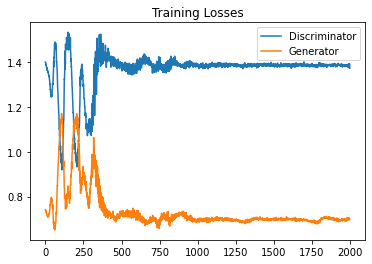

In [16]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()



### Generating sinusoid

In [17]:
sample_test_noise = torch.randn(num_of_points, 1)
generated = G(sample_test_noise)

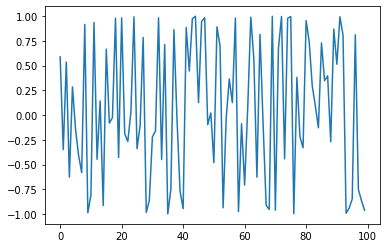

In [18]:
signal = [x for x in generated]
plt.plot(signal)

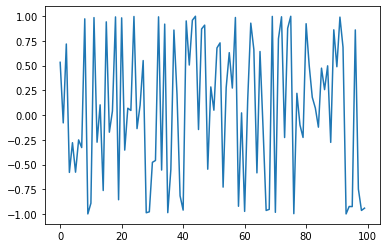

In [19]:
generated2 = G(sample_test_noise)
signal = [x for x in generated2]
plt.plot(signal)